In [1]:
!pip install rasterio
!pip install wandb

You should consider upgrading via the '/home/mcgrau/PycharmProjects/SS22_AIML/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/mcgrau/PycharmProjects/SS22_AIML/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import torchvision.transforms as transforms

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import wandb
import pandas as pd
from PIL import Image

In [4]:
# create models sub-directory inside the Colab Notebooks directory
models_directory = '/home/mcgrau/PycharmProjects/SS22_AIML/models'
test_directory = '/home/mcgrau/PycharmProjects/SS22_AIML/data/testset'

In [5]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

In [6]:
# change this to your eurosat path
eurosat_dir = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

In [7]:
sample_idx = 111
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]
print(label)

PermanentCrop


In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled[2, 2, 2, 2]
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [9]:
!nvidia-smi

Mon Apr 25 21:30:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P5     8W /  N/A |     13MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [11]:
class SatelliteDataset(Dataset):
    """Create own dataset."""

    def __init__(self, transform=False):
        self.eurosat_dir = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
        self.samples = glob.glob(os.path.join(self.eurosat_dir, "*", "*.tif"))
        self.transform = transform

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = self.samples[idx]
        label = input.split('/')[-1].split('_')[0]
        label = class_to_idx[label]
        with rio.open(input, "r") as d:
          image = d.read([1,2,3,4,5,6,7,8,9,11,12,13]).astype(int)
          image = reshape_as_image(image)

        if self.transform:
            image = transforms.ToTensor()(image)

        return image, label

In [12]:
trainData = SatelliteDataset(transform = True)

In [13]:
import torchvision.models as models

pretrained = models.googlenet(pretrained = True)


In [15]:
print(pretrained)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:

class MyGoogLeNet(nn.Module):
    def __init__(self, my_pretrained_model):
        super(MyGoogLeNet, self).__init__()
        self.pretrained = my_pretrained_model
        self.my_new_layers = nn.Sequential(nn.Linear(1000, 10),
                                           nn.ReLU(),
                                           nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x


In [17]:
model = MyGoogLeNet(my_pretrained_model=pretrained)
model

MyGoogLeNet(
  (pretrained): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [18]:
model = model.to(device)

In [19]:
!nvidia-smi

Mon Apr 25 21:30:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P5     6W /  N/A |   1006MiB /  7982MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

In [21]:
learning_rate = 0.001
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [24]:
num_epochs = 20
mini_batch_size = 1000
train_loader = DataLoader(trainData, batch_size=mini_batch_size, shuffle=True, num_workers=0)

In [26]:
torch.autograd.set_detect_anomaly(False)

# start monitoring
#wandb.init()

# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_loader):

        # push mini-batch data to computation device
        images = images.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.float)

        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        labels=labels.to(torch.int64)

        # determine classification loss
        loss = nll_loss(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # set filename of actual model
    model_name = 'googlenet_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    if (epoch % 10) == 0 or epoch == (num_epochs - 1):
      torch.save(model.state_dict(), os.path.join(models_directory, model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20220425-20:21:10] epoch: 0 train-loss: 0.011825672161110022
[LOG 20220425-20:22:22] epoch: 1 train-loss: 0.01112628607424321
[LOG 20220425-20:23:35] epoch: 2 train-loss: 0.007102326908217812
[LOG 20220425-20:24:49] epoch: 3 train-loss: 0.00542723482336711
[LOG 20220425-20:26:02] epoch: 4 train-loss: 0.005510524505990799
[LOG 20220425-20:27:15] epoch: 5 train-loss: 0.005128144941948078
[LOG 20220425-20:28:28] epoch: 6 train-loss: 0.01002304417003567
[LOG 20220425-20:29:43] epoch: 7 train-loss: 0.012814717147395842
[LOG 20220425-20:30:57] epoch: 8 train-loss: 0.010645742622997474
[LOG 20220425-20:32:11] epoch: 9 train-loss: 0.01132418949122506
[LOG 20220425-20:33:25] epoch: 10 train-loss: 0.015870233652768313
[LOG 20220425-20:34:40] epoch: 11 train-loss: 0.024211841186991444
[LOG 20220425-20:35:54] epoch: 12 train-loss: 0.009612840453714685
[LOG 20220425-20:37:08] epoch: 13 train-loss: 0.008124736644310394
[LOG 20220425-20:38:21] epoch: 14 train-loss: 0.0091807732048134
[LOG 202204

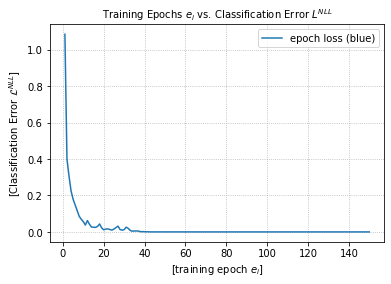

In [21]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

In [22]:
print(test_directory)

/home/mcgrau/PycharmProjects/SS22_AIML/data/testset


In [23]:
testSamples = glob.glob(os.path.join(test_directory, "*.npy"))
len(testSamples)

4232

In [24]:
class testDataset(Dataset):
    def __init__(self, test_directory, transform=False):
        self.files = glob.glob(os.path.join(test_directory, "*.npy"))
        self.transform = transform

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):
        item = self.files[idx]
        image = np.load(item).astype(int)
        number = int(item.split('/')[-1].split('_')[1].split('.')[0])

        if self.transform:
          image = transforms.ToTensor()(image).to(torch.float)

        return image, number

In [25]:
testData = testDataset(test_directory = test_directory, transform = True)

In [26]:
test_loader = DataLoader(testData, shuffle=False)

In [27]:
# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'cifar10_model_epoch_200.pth')

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = RESNET18()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

NameError: name 'RESNET18' is not defined

In [ ]:
# set model in evaluation mode
best_model.eval()

In [ ]:
predictions = []
numbers = []

for i, (images, nums) in enumerate(test_loader):
    # run forward pass through the network
    pred = torch.argmax(best_model(images), dim=1)
    predictions.append(pred.int().item())
    numbers.append(nums.int().item())

In [ ]:
print(len(predictions))

In [ ]:
print(numbers)

In [ ]:
predClasses = np.vectorize(idx_to_class.get)(predictions)

d = {'test_id': numbers, 'label': predClasses}
predData = pd.DataFrame(data = d)
predData = predData.sort_values(by=['test_id'])
print(predData.head(10))

In [ ]:
print(len(predData))

In [ ]:
predData.to_csv(os.path.join(models_directory,'submission.csv'), index = False)

In [ ]:
idx_to_class

In [ ]:
print(predictions[0])

In [ ]:
np.unique(preds)